# Pokemon Type Prediction
Given the base stats, names, and images of a Pokemon, train a model using supervised learning that is able to classify a Pokemon's type.

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\chamu\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [4]:
# Model helpers and scorers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Actual models -- add to these
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import tensorflow as tf
import keras 
from keras import layers
import cv2
from tqdm import tqdm
import re
from keras_preprocessing.image import img_to_array
import torch
from torchvision import datasets, transforms
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import random

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython import display
import os  # fix bug that crashes kernel
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Data Preprocessing
For data preprocessing, we:
1. Remove rows with invalid primary types
2. Drop unneeded columns
3. Extract the features and labels
4. Make train-test splits

In [43]:
pokedex = pd.read_csv('data/Pokedex_Cleaned.csv', encoding='latin-1')
pokedex

,#,Name,Primary Type,Secondary Type,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,Variant
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,NaN
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,NaN
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,NaN
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,NaN
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1004,Chi-Yu,Dark,Fire,570,55,80,80,135,120,100,NaN
1169,1005,Roaring Moon,Dragon,Dark,590,105,139,71,55,101,119,NaN
1170,1006,Iron Valiant,Fairy,Fighting,590,74,130,90,120,60,116,NaN
1171,1007,Koraidon,Fighting,Dragon,670,100,135,115,85,100,135,NaN


In [44]:
primary_types = pokedex['Primary Type']
primary_types.value_counts()  # need to remove rows that aren't types

Water       147
Normal      130
Grass       102
Bug          99
Psychic      76
Electric     73
Fire         73
Rock         67
Dark         56
Dragon       47
Ground       47
Poison       46
Fighting     46
Ghost        46
Steel        42
Fairy        32
Ice          27
Flying       12
Null          2
Male          1
Female        1
Rockruff      1
Name: Primary Type, dtype: int64

In [45]:
not_types = {"Null", "Male", "Female", "Rockruff"}
pokedex = pokedex.loc[~pokedex['Primary Type'].isin(not_types)]  # remove rows with invalid types
primary_types = pokedex['Primary Type']
primary_types.value_counts()  # bad rows are gone

Water       147
Normal      130
Grass       102
Bug          99
Psychic      76
Fire         73
Electric     73
Rock         67
Dark         56
Ground       47
Dragon       47
Fighting     46
Poison       46
Ghost        46
Steel        42
Fairy        32
Ice          27
Flying       12
Name: Primary Type, dtype: int64

In [46]:
# Drop irrelevant rows, columns, reorder name
pokemon_names = pokedex['Name'].copy()
pokedex_relevant = pokedex.drop(['#', 'Name', 'Secondary Type', 'Total', 'Variant'], axis=1)
pokedex_relevant['Name'] = pokemon_names
pokedex_relevant = pokedex_relevant.drop_duplicates(subset=["Name"], keep='last')
pokedex_relevant

,Primary Type,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,Name
0,Grass,45,49,49,65,65,45,Bulbasaur
1,Grass,60,62,63,80,80,60,Ivysaur
3,Grass,80,100,123,122,120,80,Venusaur
4,Fire,39,52,43,60,50,65,Charmander
5,Fire,58,64,58,80,65,80,Charmeleon
...,...,...,...,...,...,...,...,...
1168,Dark,55,80,80,135,120,100,Chi-Yu
1169,Dragon,105,139,71,55,101,119,Roaring Moon
1170,Fairy,74,130,90,120,60,116,Iron Valiant
1171,Fighting,100,135,115,85,100,135,Koraidon


In [47]:
pokedex_relevant.Name.tolist()

['Bulbasaur',
 'Ivysaur',
 'Venusaur',
 'Charmander',
 'Charmeleon',
 'Charizard',
 'Squirtle',
 'Wartortle',
 'Blastoise',
 'Caterpie',
 'Metapod',
 'Butterfree',
 'Weedle',
 'Kakuna',
 'Beedrill',
 'Pidgey',
 'Pidgeotto',
 'Pidgeot',
 'Rattata',
 'Raticate',
 'Spearow',
 'Fearow',
 'Ekans',
 'Arbok',
 'Pikachu',
 'Raichu',
 'Sandshrew',
 'Sandslash',
 'Nidorina',
 'Nidoqueen',
 'Nidoran?',
 'Nidorino',
 'Nidoking',
 'Clefairy',
 'Clefable',
 'Vulpix',
 'Ninetales',
 'Jigglypuff',
 'Wigglytuff',
 'Zubat',
 'Golbat',
 'Oddish',
 'Gloom',
 'Vileplume',
 'Paras',
 'Parasect',
 'Venonat',
 'Venomoth',
 'Diglett',
 'Dugtrio',
 'Meowth',
 'Persian',
 'Psyduck',
 'Golduck',
 'Mankey',
 'Primeape',
 'Growlithe',
 'Arcanine',
 'Poliwag',
 'Poliwhirl',
 'Poliwrath',
 'Abra',
 'Kadabra',
 'Alakazam',
 'Machop',
 'Machoke',
 'Machamp',
 'Bellsprout',
 'Weepinbell',
 'Victreebel',
 'Tentacool',
 'Tentacruel',
 'Geodude',
 'Graveler',
 'Golem',
 'Ponyta',
 'Rapidash',
 'Slowpoke',
 'Slowbro',
 'Mag

In [48]:
# extract features and labels
features = pokedex_relevant.iloc[:, 1:-1].values.astype(float)
# normalize numbers
for feature in features:
    s = sum(feature)
    feature /= s
labels = pokedex_relevant.iloc[:, 0].values
features, labels

(array([[0.14150943, 0.15408805, 0.15408805, 0.20440252, 0.20440252,
         0.14150943],
        [0.14814815, 0.15308642, 0.15555556, 0.19753086, 0.19753086,
         0.14814815],
        [0.128     , 0.16      , 0.1968    , 0.1952    , 0.192     ,
         0.128     ],
        ...,
        [0.12542373, 0.22033898, 0.15254237, 0.20338983, 0.10169492,
         0.19661017],
        [0.14925373, 0.20149254, 0.17164179, 0.12686567, 0.14925373,
         0.20149254],
        [0.14925373, 0.12686567, 0.14925373, 0.20149254, 0.17164179,
         0.20149254]]),
 array(['Grass', 'Grass', 'Grass', ..., 'Fairy', 'Fighting', 'Electric'],
       dtype=object))

In [49]:
# train test splits -- stats
# Stratify on labels to ensure each class has equal proportions
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify=labels, random_state=42)

## Decision Tree Approach using Entropy

In [50]:
# Decision tree with entropy
clf_entropy = DecisionTreeClassifier(
        criterion = "entropy")
# Performing training
entropy_model = clf_entropy.fit(X_train, y_train)

# Prediction using entropy, display results

print("For test set:")
y_pred = entropy_model.predict(X_test)
print("Confusion Matrix: ",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = entropy_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)  # high train accuracy but low test accuracy... potentially overfitting?

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  [[4 0 0 2 1 1 1 0 0 3 2 0 0 1 1 1 1 0]
 [0 1 1 0 0 0 1 0 0 2 1 0 2 0 0 1 0 0]
 [0 0 1 2 0 1 0 0 0 0 1 0 1 0 0 1 0 0]
 [0 0 2 3 0 0 0 0 0 1 1 0 2 1 1 0 1 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 3]
 [0 1 1 0 1 2 0 0 0 0 0 0 2 0 0 0 0 1]
 [3 1 2 0 0 0 0 0 3 0 0 0 1 1 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 1 0 1 0 2 1 0 0 0]
 [1 1 1 0 0 1 0 0 0 9 1 0 2 1 0 0 0 2]
 [1 1 1 0 0 1 0 0 0 0 2 0 1 0 0 1 1 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 2 1 0 2 0 0 0 1 2 0 7 3 0 1 0 4]
 [0 1 0 0 1 0 0 0 0 2 1 0 3 0 0 0 0 0]
 [1 0 0 2 2 1 1 0 0 3 0 0 0 0 1 0 0 1]
 [2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 1 5]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 1 1]
 [1 0 2 1 1 1 2 1 0 2 1 1 5 1 0 1 2 5]]
Accuracy :  19.801980198019802
Report :                precision    recall  f1-score   support

         Bug       0.25      0.22      0.24        18
        Dark       0.17      0.11      0.13         9
      Dragon       0.08      0.14      0.10         7
    El

# Decision Tree Hyperparameter Tuning using GridSearchCV (instead of validation set)


In [53]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 'scale', 'scale', 'auto'],
              'kernel': ['rbf', 'linear'],
              'random_state': [42],  # remove randomness
              'class_weight': ['balanced', None]}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print("BEST PARAMS", grid.best_params_)

# print how our model looks after hyper-parameter tuning
print("BEST ESTIMATOR", grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print("CLASSIFICATION REPORT\n", classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.130 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.087 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.062 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.075 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear, random_state=42;, score=0.130 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear, random_state=42;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear, random_state=42;, score=0.081 total time=   0.0s
[CV 4/5] END C=0.1, clas

c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# SVM

In [13]:
svc_class = SVC(kernel='rbf')

# SVM training
svm_model = svc_class.fit(X_train,y_train)

# Prediction 
print("For test set:")
y_pred = svm_model.predict(X_test)
print("Confusion Matrix: ",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = svm_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  [[ 8  0  0  1  0  1  0  0  0  0  0  0  2  0  3  0  1  2]
 [ 1  0  0  0  0  0  1  0  0  0  0  0  4  0  1  0  0  2]
 [ 1  0  0  1  0  0  1  0  0  0  0  0  2  0  0  0  0  2]
 [ 0  0  0  3  0  0  2  0  0  1  0  0  2  0  2  0  0  2]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  1  0  1  0  0  3]
 [ 0  0  0  0  0  3  1  0  0  0  0  0  3  0  0  0  0  1]
 [ 0  1  0  1  0  1  3  0  0  1  0  0  0  0  1  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  3  3  0  0]
 [ 3  0  0  2  0  0  0  0  0  3  0  0  3  0  1  1  0  6]
 [ 2  0  0  0  0  1  0  0  0  0  2  0  3  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  1]
 [ 2  0  0  0  0  2  0  0  0  0  1  0 13  0  0  0  0  5]
 [ 1  0  0  0  0  1  0  0  0  2  0  0  3  0  0  0  0  1]
 [ 0  0  0  0  0  1  0  0  0  2  0  0  2  0  5  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  1  1  0  0  0  1  3  0  3]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2  1  2

c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Confusion Matrix:  [[28  0  0  6  0  3  4  0  0  4  1  0 17  0  2  2  1  5]
 [ 3  1  0  1  0  1  8  0  0  2  0  0 10  0  1  2  0  7]
 [ 1  0  0  0  0  3  4  0  0  2  0  0  6  0  1  0  1 12]
 [ 3  0  0 13  0  0 11  0  0  3  0  0  3  0  4  0  0  9]
 [ 5  0  0  0  0  1  1  0  0  3  0  0  4  0  1  0  0  8]
 [ 2  0  0  0  0 13  1  0  0  1  1  0 12  0  0  0  0  2]
 [ 0  0  0  0  0  1 22  0  0  5  0  0 10  0  3  1  0  8]
 [ 1  0  0  3  0  0  2  0  0  0  0  0  2  0  0  0  0  1]
 [ 7  0  0  1  0  1  2  0  0  6  0  0  1  0  7  1  0  3]
 [ 6  0  0  2  0  3  6  0  0 23  1  0  8  0  3  1  1 23]
 [ 4  0  0  0  0  3  0  0  0  1  9  0  9  0  0  0  2  6]
 [ 1  0  0  0  0  0  0  0  0  1  0  2  1  0  1  1  0 11]
 [ 3  0  0  1  0  0  2  0  0  4  0  0 67  0  1  0  0 15]
 [ 1  0  0  3  0  1  3  0  0  1  0  0 11  0  1  1  0  8]
 [ 2  0  0  4  0  0  4  0  0  5  0  0  0  0 18  1  0 14]
 [ 6  0  0  0  0  2  1  0  0  2  0  0  5  0  2 22  0  6]
 [ 7  0  0  0  0  0  0  0  0  0  1  0  2  0  1  3  6  7]
 [ 4  0  0  

c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# SVM Hyperparameter Tuning using GridSearchCV (instead of validation set)

In [41]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'],
              'kernel': ['rbf', 'sigmoid'],
              'random_state': [42], # remove randomness
              'class_weight': ['balanced', None]}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)


# print best parameter after tuning
print("BEST PARAMS",grid.best_params_)

# print how our model looks after hyper-parameter tuning
print("BEST ESTIMATOR",grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print("CLASSIFICATION REPORT\n",classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.130 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.087 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.062 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.075 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=sigmoid, random_state=42;, score=0.130 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=sigmoid, random_state=42;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=sigmoid, random_state=42;, score=0.081 total time=   0.0s
[CV 4/5] END C=0.1, c

c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# GAN

This doesn't seem viable for generating more data points. See the "*outputs/generated_pokemon_images_7x7.png*" file for the results.

Code from https://www.kaggle.com/code/scratchpad/notebook3b2c42d3e9/edit

In [14]:
# # to get the files in proper order
# def sorted_alphanumeric(data):  
#     convert = lambda text: int(text) if text.isdigit() else text.lower()
#     alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
#     return sorted(data,key = alphanum_key)
# # defining the size of the image
# SIZE = 128
# _img = []
# path = 'data/images'
# files = os.listdir(path)
# files = sorted_alphanumeric(files)
# for i in tqdm(files):    
#     img = cv2.imread(path + '/'+i,1)
#     # open cv reads images in BGR format so we have to convert it to RGB
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     #resizing image
#     img = cv2.resize(img, (SIZE, SIZE))
#     img = (img - 127.5) / 127.5
#     img = img.astype(float)
#     _img.append(img_to_array(img))

In [15]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
# plot_images(6)

In [16]:
# batch_size = 32  # try different numbers here
# dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [17]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [18]:
# generator = Generator()
# generator.summary()

In [19]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  

In [20]:
# discriminator = Discriminator()
# discriminator.summary()

In [21]:
# noise = np.random.normal(-1,1,(1,100))
# img = generator(noise)
# plt.imshow(img[0,:,:,0])
# plt.show()

In [22]:
# optimizer = tf.keras.optimizers.legacy.RMSprop(
#         learning_rate=.0001,
#         clipvalue=1.0,
#         decay=1e-8
#     )
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [24]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [25]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()
    plt.savefig('generated_pokemon_images_7x7.png')

In [26]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [25]:
# train(5,dataset)  # COMMENTED OUT TO AVOID TRAINING AGAIN
# i had train model previously for more than 10 epochs so generated images are quite good

In [26]:
#plot_generated_images(1)

In [27]:
#plot_generated_images(2)

In [28]:
#plot_generated_images(5)

In [29]:
#plot_generated_images(7)

In [30]:
#generator.save('generator.h5')
#discriminator.save("discriminator.h5")

# MLP

Code from https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data/notebook

In [27]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

In [28]:
PATH = 'data/images'
data_dir = PATH + '/train'

transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
training_data = datasets.ImageFolder(data_dir, transform=transform)
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=32)

<AxesSubplot:>

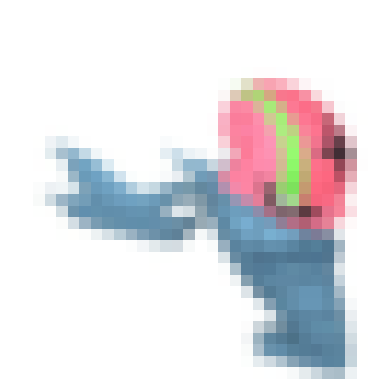

In [29]:
# Run this to test your data loader
images, labels = next(iter(train_dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [30]:
PATH = 'data/images'
data_dir = PATH + '/test'

transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
test_data = datasets.ImageFolder(data_dir, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32)

<AxesSubplot:>

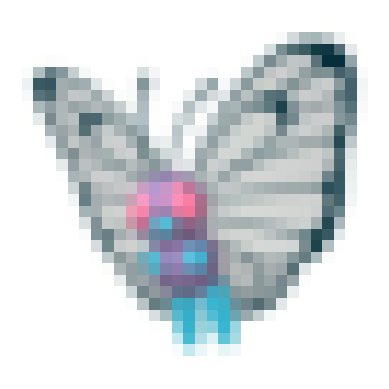

In [31]:
# Run this to test your data loader
images, labels = next(iter(test_dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [32]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 32, 32])
Shape of y: torch.Size([32]) torch.int64


c:\users\chamu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)
  


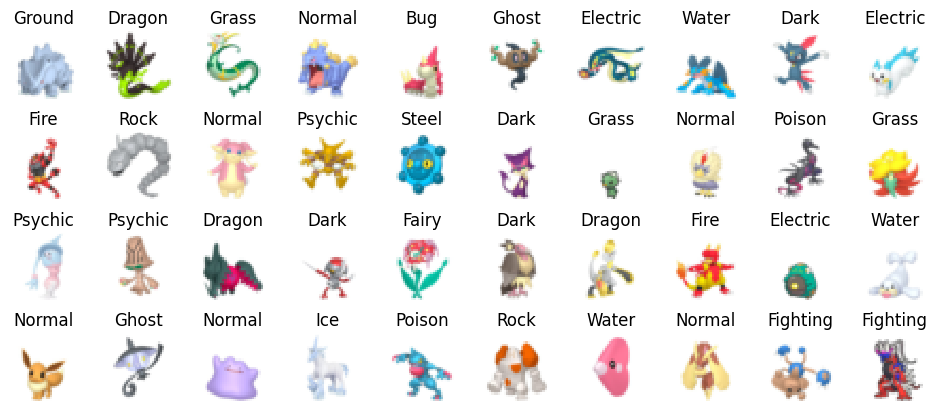

In [33]:
# Let's fetch a few items from the training set and visualize it

# Corresponding class names 
class_names = sorted(pokedex_relevant['Primary Type'].unique().tolist())

# Visualize dataset sample with random samples
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        selector_index = random.randint(0,len(training_data)-1)
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = training_data[selector_index]
        plt.imshow(np.fliplr(np.rot90(X.T, k=3, axes=(0, 1))), interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [34]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        # Using the nn.Sequential function, define a 3 layer MLP
        # with ReLU activation function
        # with sizes of input and output nodes as:
        # layer1: in: 28*28, out: 512
        # layer2: in: 512, out: 512
        # layer3: in:512, out: 10 (for 10 output classes)
        self.linear_relu_stack = nn.Sequential(nn.Linear(32*32*3,2048),
                                               nn.ReLU(),
                                               nn.Linear(2048,2048),
                                               nn.ReLU(),
                                               nn.Linear(2048,1024),
                                               nn.ReLU(),
                                               nn.Linear(1024,1024),
                                               nn.ReLU(),
                                               nn.Linear(1024,512),
                                               nn.ReLU(),
                                               nn.Linear(512,512),
                                               nn.ReLU(),
                                               nn.Linear(512,18))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=18, bias=True)
  )
)


In [110]:
# Use cross-entropy loss as the loss function
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2

# Define a pytorch optimizer using stochastic gradient descent (SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [111]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    # set the model to train mode
    model.train()
    
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # Compute training loss
        loss = loss_fn(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        
        # Calculate model gradients from the loss and optimize the network
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses.append(loss)
        
    return np.array(losses).mean()

In [112]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Set the model to eval mode
    model.eval()
    
    test_loss, correct = 0, 0
    with torch.no_grad():	# no_grad mode doesn't compute gradients
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

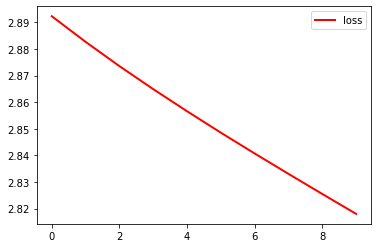

<ipython-input-113-3513c13983b0>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure()


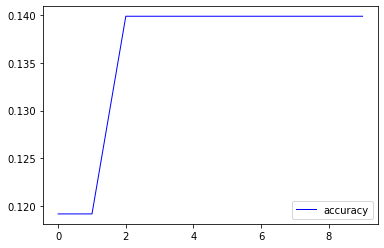

Done!


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

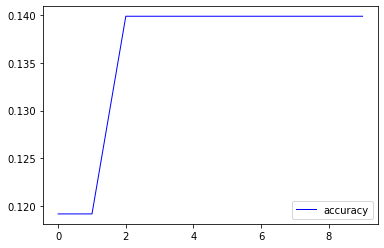

In [113]:
epochs = 10

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(train_dataloader, model, loss_fn, optimizer))
    history['accuracies'].append(test(test_dataloader, model, loss_fn))
    
    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("Done!")

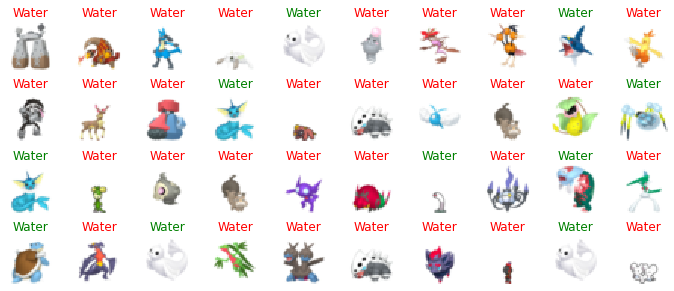

In [116]:
# Make predictions on random 40 test data items using the trained model and visualize them
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        selector_index = random.randint(0,len(test_data)-1)
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = test_data[selector_index]
        y_pred = model(X.to(device)[None,...])
        y_pred = y_pred.argmax(1)
        plt.imshow(np.fliplr(np.rot90(X.T, k=3, axes=(0, 1))), interpolation="nearest")
        plt.axis('off')
        if y == y_pred:
            plt.title(class_names[y_pred], fontsize=12, color='g')
        else:
            plt.title(class_names[y_pred], fontsize=12, color='r')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()  # All water!!

### Training:
Do SVM, add images in addition to classic features using MLP (first notebook assignment), CNN (followup notebook assignment), 
get vector, normalize, do softmax to pick one class,
look into resnet, and GAN for data augmentation (the Kaggle link--generates new images)

Consider other ways of data augmentation like rotation, shifts, background changes?

### Evaluation:
Precision, recall, F1 PER LABEL, confusion matrix

Use validation set (10% from training) for neural networks to fine-tune parameters.

Add them back to training set when the parameters are producing better results (so it's 80% for training again).

### Error Analysis:
See which classes are harder to identify (e.g. psychic, normal, ...)

See learning curves to check if increasing training data helps or not.

### Resources: 
https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet#:~:text=Own%20ResNet%20Architecture-,ResNet%20Architecture,layers%2C%20which%20outperform%20shallower%20networks.
https://pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html#:~:text=ResNet%2D152%20from%20Deep%20Residual,5.
https://www.kaggle.com/code/scratchpad/notebook3b2c42d3e9/edit

Identify Pokemon  team 5: 
1. SVM 
2. Images => CNN => MLP classification 
3. ResNet => MLP classification 
4. Data augmentation with GAN or other image transformations => them use the 2 and 3 models to classify
5. Evaluation : Label (Precision, recall, F1 per label and confusion matrix. )
6. Tuning parameters using 100 examples from training data and using is as development set. 
7. Error analysis 
8. Learning curve => number of data and number of epochs used.